In [63]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
import yfinance as yf
import pandas as pd

# Define tickers
tickers = ['TSLA', 'BND', 'SPY']

# Set time period
start_date = '2020-01-01'
end_date = '2025-03-01'

# Fetch historical data
data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}

# Save data to CSV files
for ticker, df in data.items():
    df.to_csv(f'../src/data/{ticker}_historical_data.csv')

# Display first few rows for each
tesla_data = data['TSLA'].head()
bnd_data = data['BND'].head()
spy_data = data['SPY'].head()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
print("Tesla (TSLA) Sample Data:")
tesla_data.head()


Tesla (TSLA) Sample Data:


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500


In [66]:
print("\nBND Sample Data:")
bnd_data.head()



BND Sample Data:


Price,Close,High,Low,Open,Volume
Ticker,BND,BND,BND,BND,BND
Date,,,,,
2020-01-02,72.948761,73.070385,72.914010,72.957450,5511000
2020-01-03,73.209412,73.226790,73.061726,73.131227,5368300
2020-01-06,73.122505,73.244129,73.070382,73.235447,3710400
2020-01-07,73.061676,73.148549,73.035615,73.148549,3029900
2020-01-08,72.948761,73.148569,72.887949,73.087757,3674400


In [67]:
print("\nSPY Sample Data:")
spy_data.head()


SPY Sample Data:


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2020-01-02,301.194916,301.213476,299.025448,299.961853,59151200
2020-01-03,298.914215,300.054588,297.699684,297.755309,77709700
2020-01-06,300.054565,300.138003,297.013570,297.134101,55653900
2020-01-07,299.210876,299.961845,298.756566,299.479722,40496400
2020-01-08,300.805511,302.038574,299.155231,299.405545,68296000


In [68]:
# Convert date to datetime format for analysis
for ticker in tickers:
    data[ticker].index = pd.to_datetime(data[ticker].index)


In [70]:
# Handle missing values by forward filling
data = {ticker: df.fillna(method='ffill') for ticker, df in data.items()}


C:\Users\Administrator.MMCY\AppData\Local\Temp\ipykernel_15632\3236631127.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = {ticker: df.fillna(method='ffill') for ticker, df in data.items()}


In [71]:
# Display basic statistics
for ticker, df in data.items():
    print(f"{ticker} Data Statistics:")
    print(df.describe())
    print("\n")

TSLA Data Statistics:
Price         Close         High          Low         Open        Volume
Ticker         TSLA         TSLA         TSLA         TSLA          TSLA
count   1297.000000  1297.000000  1297.000000  1297.000000  1.297000e+03
mean     218.288303   223.307049   213.119270   218.410725  1.241395e+08
std       86.966667    89.053018    84.980309    87.227520  8.130709e+07
min       24.081333    26.990667    23.367332    24.980000  2.940180e+07
25%      175.000000   178.570007   172.220001   174.869995  7.504590e+07
50%      222.179993   227.816666   217.333328   223.166672  1.010776e+08
75%      264.510010   269.489990   259.890015   265.000000  1.425328e+08
max      479.859985   488.540009   457.510010   475.899994  9.140820e+08


BND Data Statistics:
Price         Close         High          Low         Open        Volume
Ticker          BND          BND          BND          BND           BND
count   1297.000000  1297.000000  1297.000000  1297.000000  1.297000e+03
mean  

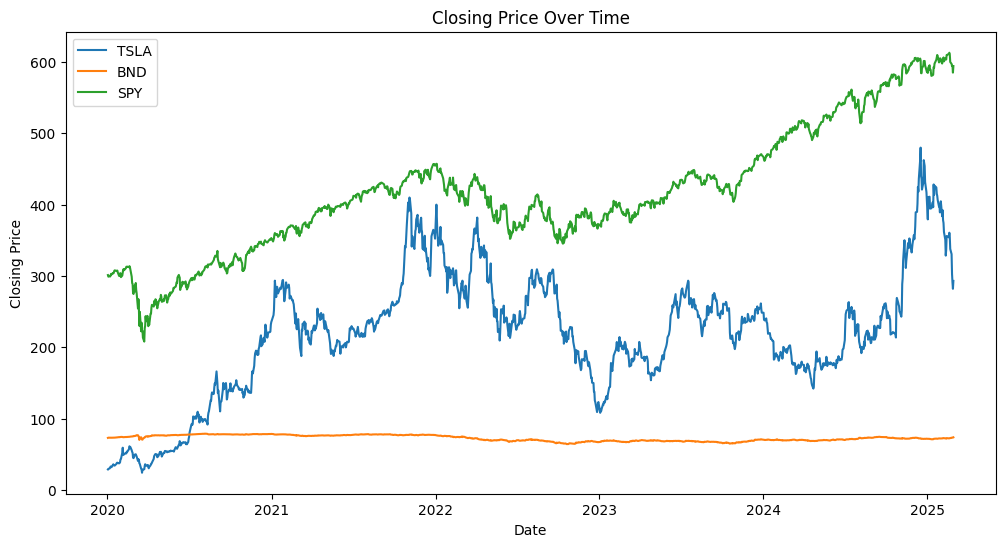

In [72]:
# Visualize closing price trends
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data[ticker]['Close'], label=ticker)
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [73]:
# Compute daily returns
daily_returns = {ticker: df['Close'].pct_change().dropna() for ticker, df in data.items()}
